<a href="https://colab.research.google.com/github/daniil-chepela/kirsch-problem-fea/blob/main/kirsch_problem_fea.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import re

nu = 0.3
E = 200000000000
sigma_y = 210000000
D = E/(1-nu*nu)*np.array(( (1, nu, 0),
                           (nu, 1, 0),
                           (0, 0, (1-nu)/2) ))

class node:
  def __init__(self, u=None, v=None, x=None, y=None, n=None):
    self.bu = u # x axis initial displacement (from boundary conditions)
    self.bv = v # y axis initial displacement (from boundary conditions)
    self.u = 0 if u == None else u # x axis displacement
    self.v = 0 if v == None else v # y axis displacement
    self.x = x # x coordinate
    self.y = y # y coordinate
    self.x0 = x # initial x coordinate
    self.y0 = y # initial y coordinate
    self.n = n # node number
    self.F = np.array([0.0, 0.0]) # nodal force

class triangle_element:
    def __init__(self, N1=None, N2=None, N3=None, n=None):
        self.N = (N1, N2, N3) # self.N = {1: N1, 2:N2, 3:N3}
        self.N1 = N1 # nodal point 1
        self.N2 = N2 # nodal point 2
        self.N3 = N3 # nodal point 3
        self.n = n # element number
        
        self.set_delta()
        self.set_B()
        self.set_stiffness()
        self.set_eps()
        self.eps0 = self.eps
        self.sigma0 = np.zeros(3)
        self.sigma = np.zeros(3)
        self.sigma_mises0 = 0
        self.sigma_mises = 0
        self.F = np.zeros(6)
        self.plasticity_flag = False

    def new_step(self):
      #self.set_delta()
      #self.set_B()
      #self.set_stiffness()
      self.eps0 = self.eps
      self.sigma0 = self.sigma
      self.sigma_mises0 = self.sigma_mises
      self.N1.F = np.array([0.0, 0.0])
      self.N2.F = np.array([0.0, 0.0])
      self.N3.F = np.array([0.0, 0.0])

    def set_delta(self):
      self.delta = 0.5 * np.linalg.det(np.array( [[1, self.N1.x, self.N1.y],
                                                  [1, self.N2.x, self.N2.y],
                                                  [1, self.N3.x, self.N3.y]] ))

    def set_B(self):
      self.a = []
      self.b = [
          self.N2.y - self.N3.y,
          self.N3.y - self.N1.y,
          self.N1.y - self.N2.y
      ] 
      self.c = [
          self.N3.x - self.N2.x,
          self.N1.x - self.N3.x,
          self.N2.x - self.N1.x
      ]
      self.B = 1/(2*self.delta) * np.array([ [self.b[0], 0, self.b[1], 0, self.b[2], 0],
                                             [0, self.c[0], 0, self.c[1], 0, self.c[2]],
                                             [self.c[0], self.b[0], self.c[1], self.b[1], self.c[2], self.b[2]] ])
      
    def set_stiffness(self):
      self.stiffness = np.matmul(np.matmul(np.transpose(self.B), D), self.B) * self.delta

    def set_eps(self):
      self.eps = np.matmul(self.B, np.array( [self.N1.u, self.N1.v, self.N2.u, self.N2.v, self.N3.u, self.N3.v] ))

    def set_sigma(self):
      self.sigma = np.matmul(D, self.eps)

    def set_sigma_mises(self): 
      self.sigma_mises = pow( self.sigma[0]*self.sigma[0] - self.sigma[0]*self.sigma[1] + self.sigma[1]*self.sigma[1] +3*self.sigma[2]*self.sigma[2], 0.5)

    def set_sigma_plasticity(self):
      self.plasticity_flag = True
      self.sigma = self.sigma0 + np.matmul(self.Dep, np.array(self.eps - self.eps0))

    def set_P(self):
      self.P = np.matmul( np.transpose(self.B), self.sigma - self.sigma0 - np.matmul(self.Dep, np.array(self.eps - self.eps0) )) * self.delta
      self.N1.F = self.P[0:2]
      self.N2.F = self.P[2:4]
      self.N3.F = self.P[4:6]

    def apply_force(self, node, gforce):
      x_ksi = {self.N1.n: self.N2.x+self.N3.x,
               self.N2.n: self.N3.x+self.N1.x,
               self.N3.n: self.N1.x+self.N2.x}
      y_ksi = {self.N1.n: self.N2.y+self.N3.y,
               self.N2.n: self.N3.y+self.N1.y,
               self.N3.n: self.N1.y+self.N2.y}
      lenght = {self.N1.n: pow(pow(self.N2.y-self.N3.y, 2) + pow(self.N2.x-self.N3.x, 2), 0.5),
                self.N2.n: pow(pow(self.N3.y-self.N1.y, 2) + pow(self.N3.x-self.N1.x, 2), 0.5),
                self.N3.n: pow(pow(self.N1.y-self.N2.y, 2) + pow(self.N1.x-self.N2.x, 2), 0.5)}
      self.NN = 1/(2*self.delta) * np.array([ [self.N2.x*self.N3.y*2 - self.N3.x*self.N2.y*2 + (self.N2.y-self.N3.y)*x_ksi[node] + (self.N3.x-self.N2.x)*y_ksi[node], 0],
                                             [0, self.N2.x*self.N3.y*2 - self.N3.x*self.N2.y*2 + (self.N2.y-self.N3.y)*x_ksi[node] + (self.N3.x-self.N2.x)*y_ksi[node]],
                                             [self.N3.x*self.N1.y*2 - self.N1.x*self.N3.y*2 + (self.N3.y-self.N1.y)*x_ksi[node] + (self.N1.x-self.N3.x)*y_ksi[node], 0],
                                             [0, self.N3.x*self.N1.y*2 - self.N1.x*self.N3.y*2 + (self.N3.y-self.N1.y)*x_ksi[node] + (self.N1.x-self.N3.x)*y_ksi[node]],
                                             [self.N1.x*self.N2.y*2 - self.N2.x*self.N1.y*2 + (self.N1.y-self.N2.y)*x_ksi[node] + (self.N2.x-self.N1.x)*y_ksi[node], 0],
                                             [0, self.N1.x*self.N2.y*2 - self.N2.x*self.N1.y*2 + (self.N1.y-self.N2.y)*x_ksi[node] + (self.N2.x-self.N1.x)*y_ksi[node]]  ])
      
      self.F = np.matmul(self.NN, gforce)*lenght[node]*0.5
      self.N1.F += self.F[0:2]
      self.N2.F += self.F[2:4]
      self.N3.F += self.F[4:6]

    def set_Dep(self):
      self.dF = np.array(( 1.5*(self.sigma[0]-self.sigma[1])/sigma_y,
                           1.5*(self.sigma[1]-self.sigma[0])/sigma_y,
                           self.sigma[2]/sigma_y
      ))
      self.Dep = D - np.matmul(np.matmul(D, self.dF), np.transpose(self.dF))* D / np.matmul(np.transpose(self.dF), np.matmul(D, self.dF))


def import_mesh(kfile = 'mesh.k'):
    
    mesh = {
        'elements': {},
        'nodes': {}
    }
    
    with open(kfile, 'r') as file:
        keywords = {}
        lines = file.readlines()
        for line in enumerate(lines):
            row_number = line[0]
            line = line[1].strip()
            if re.fullmatch('[*][A-Z_]+', line):
                keywords[line] = row_number
        
        for line in lines[keywords['*NODE']+1: ]:
            line = line.strip()
            if re.match('[$#]+', line):
                continue
            elif re.fullmatch('[*][A-Z_]+', line):
                break
            node_data = line.split()
            mesh['nodes'][int(node_data[0])] = node(x=float(node_data[1]),
                                                    y=float(node_data[3]),
                                                    n=int(node_data[0]))
        
        for line in lines[keywords['*ELEMENT_SHELL']+1: ]:
            if re.fullmatch('[*][A-Z_]+', line.strip()):
                break
            elif re.match('[$#]+', line):
                continue
            element_data = line.split()
            mesh['elements'][int(element_data[0])] = triangle_element(N1=mesh['nodes'][int(element_data[2])],
                                                                      N2=mesh['nodes'][int(element_data[3])],
                                                                      N3=mesh['nodes'][int(element_data[4])],
                                                                      n = int(element_data[0]))
    return mesh
        
def import_nodes(gfile):

  nodes = []

  with open(gfile, 'r') as file:
    lines = [line.strip() for line in file.readlines()]
    for line in lines:
      if re.fullmatch('[*][A-Z_]+', line) or re.match('node,', line):
        continue
      else:
        nodes.extend([int(l) for l in line.split()])
  return nodes

def import_elements(gfile):

  elements = []

  with open(gfile, 'r') as file:
    lines = [line.strip() for line in file.readlines()]
    for line in lines:
      if re.fullmatch('[*][A-Z_]+', line) or re.match('element,', line):
        continue
      else:
        elements.extend([int(re.match('[0-9]+',l)[0]) for l in line.split()])
  return elements

def get_stiffness_matrix(mesh, E, nu):
  K = np.zeros(( 2*max(mesh['nodes'].keys()), 2*max(mesh['nodes'].keys()) ))
  D = E/(1-nu*nu)*np.array(( (1, nu, 0),
                             (nu, 1, 0),
                             (0, 0, (1-nu)/2) ))
  for el in mesh['elements'].values():
    
    K[el.N1.n*2-2, el.N1.n*2-2] += el.stiffness[0][0]
    K[el.N1.n*2-1, el.N1.n*2-1] += el.stiffness[1][1]
    K[el.N1.n*2-1, el.N1.n*2-2] += el.stiffness[1][0]
    K[el.N1.n*2-2, el.N1.n*2-1] += el.stiffness[0][1]
    
    K[el.N1.n*2-2, el.N2.n*2-2] += el.stiffness[0][2]
    K[el.N1.n*2-1, el.N2.n*2-1] += el.stiffness[1][3]
    K[el.N1.n*2-1, el.N2.n*2-2] += el.stiffness[1][2]
    K[el.N1.n*2-2, el.N2.n*2-1] += el.stiffness[0][3]
    
    K[el.N1.n*2-2, el.N3.n*2-2] += el.stiffness[0][4]
    K[el.N1.n*2-1, el.N3.n*2-1] += el.stiffness[1][5]
    K[el.N1.n*2-1, el.N3.n*2-2] += el.stiffness[1][4]
    K[el.N1.n*2-2, el.N3.n*2-1] += el.stiffness[0][5]
    
    K[el.N2.n*2-2, el.N1.n*2-2] += el.stiffness[2][0]
    K[el.N2.n*2-1, el.N1.n*2-1] += el.stiffness[3][1]
    K[el.N2.n*2-1, el.N1.n*2-2] += el.stiffness[3][0]
    K[el.N2.n*2-2, el.N1.n*2-1] += el.stiffness[2][1]
    
    K[el.N2.n*2-2, el.N2.n*2-2] += el.stiffness[2][2]
    K[el.N2.n*2-1, el.N2.n*2-1] += el.stiffness[3][3]
    K[el.N2.n*2-1, el.N2.n*2-2] += el.stiffness[3][2]
    K[el.N2.n*2-2, el.N2.n*2-1] += el.stiffness[2][3]
    
    K[el.N2.n*2-2, el.N3.n*2-2] += el.stiffness[2][4]
    K[el.N2.n*2-1, el.N3.n*2-1] += el.stiffness[3][5]
    K[el.N2.n*2-1, el.N3.n*2-2] += el.stiffness[3][4]
    K[el.N2.n*2-2, el.N3.n*2-1] += el.stiffness[2][5]
    
    K[el.N3.n*2-2, el.N1.n*2-2] += el.stiffness[4][0]
    K[el.N3.n*2-1, el.N1.n*2-1] += el.stiffness[5][1]
    K[el.N3.n*2-1, el.N1.n*2-2] += el.stiffness[5][0]
    K[el.N3.n*2-2, el.N1.n*2-1] += el.stiffness[4][1]
    
    K[el.N3.n*2-2, el.N2.n*2-2] += el.stiffness[4][2]
    K[el.N3.n*2-1, el.N2.n*2-1] += el.stiffness[5][3]
    K[el.N3.n*2-1, el.N2.n*2-2] += el.stiffness[5][2]
    K[el.N3.n*2-2, el.N2.n*2-1] += el.stiffness[4][3]
    
    K[el.N3.n*2-2, el.N3.n*2-2] += el.stiffness[4][4]
    K[el.N3.n*2-1, el.N3.n*2-1] += el.stiffness[5][5]
    K[el.N3.n*2-1, el.N3.n*2-2] += el.stiffness[5][4]
    K[el.N3.n*2-2, el.N3.n*2-1] += el.stiffness[4][5]
    
  return K

def set_boundary(K, F, mesh):
  for nd in mesh['nodes'].values():
    if nd.bu != None:
        F = [force - nd.bu*K[i][2*nd.n-2] for i, force in enumerate(F)]
        F[2*nd.n-2] = nd.bu
        K[2*nd.n-2] = np.zeros_like(K[2*nd.n-2])
        K[:, 2*nd.n-2] = np.zeros_like(K[:, 2*nd.n-2])
        K[2*nd.n-2, 2*nd.n-2] = 1
    if nd.bv != None:
        F = [force - nd.bv*K[i][2*nd.n-1] for i, force in enumerate(F)]
        F[2*nd.n-1] = nd.bv
        K[2*nd.n-1] = np.zeros_like(K[2*nd.n-1])
        K[:, 2*nd.n-1] = np.zeros_like(K[:, 2*nd.n-1])
        K[2*nd.n-1, 2*nd.n-1] = 1
  return (K, F)

def draw_image(mesh):
    
    from PIL import Image, ImageDraw
    
    CANVAS_WIDTH = 1200
    CANVAS_HEIGHT = 600
    CANVAS_MARGIN_Y = 35
    CANVAS_MARGIN_X = 120
    POINT_RADIUS = 10
    LINE_WIDTH = 2
    SCALE = 14000
    COLOR = 'cyan'
  
    
    im = Image.new('RGB', (CANVAS_WIDTH, CANVAS_HEIGHT), color='gray')
    draw = ImageDraw.Draw(im)
    
    for element in mesh['elements'].values():
        draw_triangle = [
            (CANVAS_MARGIN_X + element.N1.x*SCALE, CANVAS_MARGIN_Y + element.N1.y*SCALE),
            (CANVAS_MARGIN_X + element.N2.x*SCALE, CANVAS_MARGIN_Y + element.N2.y*SCALE),
            (CANVAS_MARGIN_X + element.N3.x*SCALE, CANVAS_MARGIN_Y + element.N3.y*SCALE)
        ]
        #380, 300, 270, 225, 210
        #250, 240, 230, 220, 210
        stress = element.sigma_mises
        if stress > 270*pow(10, 6):
          fill_color = (255,0,0)#'Red'
        elif stress > 250*pow(10, 6):
          fill_color = (255,90,0)#'OrangeRed'
        elif stress > 230*pow(10,6):
          fill_color = (255,154,0)#'orange'
        elif stress > 220*pow(10, 6):
          fill_color = (255,206,0)
        elif stress > 210*pow(10,6):
          fill_color = (240,255,0)#'yellow'
        else:
          fill_color = 'cyan'
        draw.polygon(draw_triangle, fill=fill_color, outline='blue')
    return im

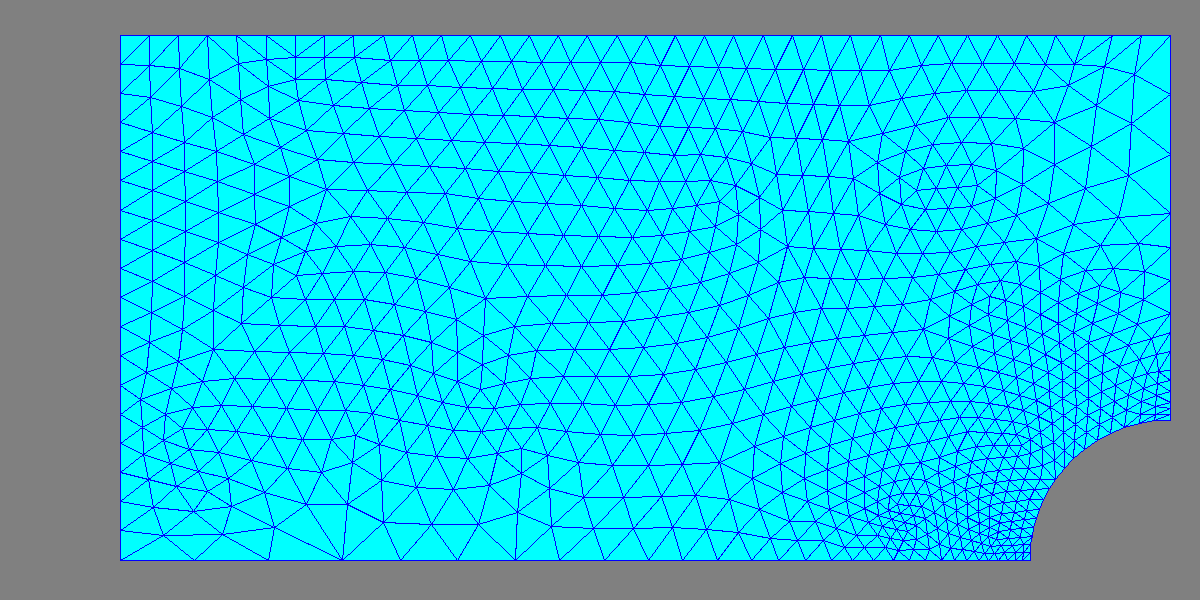

In [ ]:
mesh = import_mesh(kfile='plate_hole.k')
draw_image(mesh)

In [ ]:
left_edge = import_nodes(gfile = 'left.g')
left_elements = import_elements(gfile = 'left_el.g')
right_edge = import_nodes(gfile = 'right.g')
bottom_edge = import_nodes(gfile = 'bottom.g')

for i in right_edge:
    mesh['nodes'][i].bu = 0
    mesh['nodes'][i].u = 0
for i in bottom_edge:
  mesh['nodes'][i].bv = 0
  mesh['nodes'][i].v = 0

G = np.array([-200000000, 0]) #200*10^6 [N/m] * 37.5* 10^(-3) [m] = 7.5*10^6 [N]
FSteps = 5
for step in range(FSteps, 0, -1):

  for element in enumerate(left_elements):
    node = None
    for item in mesh['elements'][element[1]].N:
      if item.n in left_edge:
        continue
      else:
        node = item.n
        break
    mesh['elements'][element[1]].apply_force(node, G/step)

  F = np.zeros(2*max(mesh['nodes'].keys()))
  for i in left_edge:
      F[2*i-2] = mesh['nodes'][i].F[0]
      F[2*i-1] = mesh['nodes'][i].F[1]

  K = get_stiffness_matrix(mesh, E, nu)
  K, F = set_boundary(K, F, mesh)
  displacements = np.linalg.solve(K, F)

  for i in range(1, max(mesh['nodes'].keys())+1):
    mesh['nodes'][i].u = displacements[2*i-2]
    mesh['nodes'][i].v = displacements[2*i-1]
    mesh['nodes'][i].x = mesh['nodes'][i].x0 + mesh['nodes'][i].u
    mesh['nodes'][i].y = mesh['nodes'][i].y0 + mesh['nodes'][i].v

  for el in mesh['elements'].values():
    el.set_delta()
    el.set_B()
    el.set_stiffness()
    el.set_eps()
    el.set_sigma()
    el.set_sigma_mises()
    if el.sigma_mises0 >= sigma_y:
      if el.plasticity_flag == False:
        print(f"Step {FSteps+1-step}: element {el.n} plastically deforms")
      for num in range(20):
        el.set_Dep()
        el.set_P()
        if max(el.P) < 100:
          el.set_sigma_plasticity()
          break
        for node in el.N:
          F[2*node.n-2] = mesh['nodes'][node.n].F[0]
          F[2*node.n-1] = mesh['nodes'][node.n].F[1]
        K = get_stiffness_matrix(mesh, E, nu)
        K, F = set_boundary(K, F, mesh)
        displacements = np.linalg.solve(K, F)
        for i in range(1, max(mesh['nodes'].keys())+1):
          mesh['nodes'][i].u = displacements[2*i-2]
          mesh['nodes'][i].v = displacements[2*i-1]
          mesh['nodes'][i].x = mesh['nodes'][i].x0 + mesh['nodes'][i].u
          mesh['nodes'][i].y = mesh['nodes'][i].y0 + mesh['nodes'][i].v
        for el_p in mesh['elements'].values():
          el_p.set_delta()
          el_p.set_B()
          el_p.set_eps()
          el_p.set_sigma()
          el_p.set_sigma_mises()
          el_p.eps0 = el_p.eps
          el_p.sigma0 = el_p.sigma
          el_p.sigma_mises0 = el_p.sigma_mises
          el_p.new_step()
    el.new_step()
  print(f"Step {FSteps+1-step} complete")






displacements

Step 2 complete
Step 3 complete
Step 4: element 702 plastically deforms
Step 4: element 1069 plastically deforms
Step 4: element 1070 plastically deforms
Step 4: element 1347 plastically deforms
Step 4: element 1350 plastically deforms
Step 4: element 1377 plastically deforms
Step 4: element 1378 plastically deforms
Step 4: element 1379 plastically deforms
Step 4: element 1380 plastically deforms
Step 4: element 1381 plastically deforms
Step 4: element 1383 plastically deforms
Step 4: element 1385 plastically deforms
Step 4: element 1386 plastically deforms
Step 4 complete
Step 5: element 694 plastically deforms
Step 5: element 695 plastically deforms
Step 5: element 696 plastically deforms
Step 5: element 697 plastically deforms
Step 5: element 698 plastically deforms
Step 5: element 699 plastically deforms
Step 5: element 700 plastically deforms
Step 5: element 701 plastically deforms
Step 5: element 703 plastically deforms
Step 5: element 704 plastically deforms
Step 5: element 705 

array([-2.88793967e-05,  3.07485906e-06, -3.07776605e-05, ...,
        1.22618202e-05, -3.49984333e-05,  9.85288726e-06])

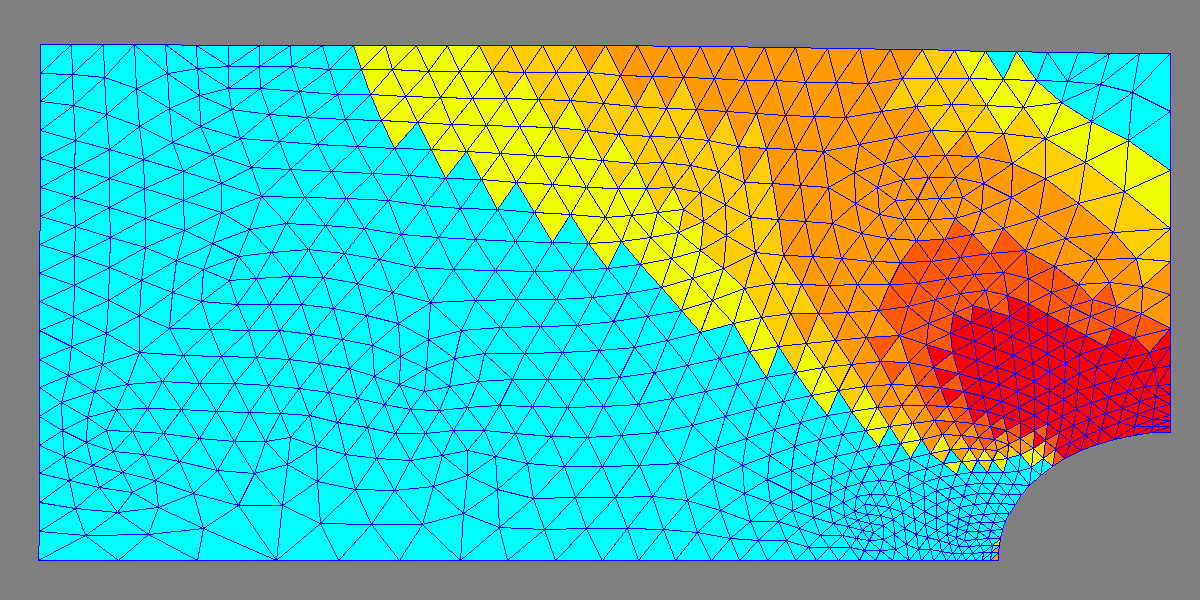

In [ ]:
DISP_SCALE = 70
for i in range(1, max(mesh['nodes'].keys())+1):
    mesh['nodes'][i].x = mesh['nodes'][i].x0 + mesh['nodes'][i].u*DISP_SCALE
    mesh['nodes'][i].y = mesh['nodes'][i].y0 + mesh['nodes'][i].v*DISP_SCALE
draw_image(mesh)

In [ ]:
!python --version

Python 3.7.13
